In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import shap

plt.style.use('fivethirtyeight')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [41]:
class LassoWrapper():
    def __init__(self, model_params={'fit_intercept': True, 'max_iter': 100000}):
        self.model_name = "lasso"
        self.search_type = 'random'
        self.param_grid = {'alpha': np.linspace(0.001, 10, 100)}
        if model_params is None:
            self.ModelClass = Lasso()
        else:
            self.ModelClass = Lasso(**model_params)

class RandomForestWrapper():
    def __init__(self, model_params=None):
        self.model_name = "random_forest"
        self.search_type = 'random'
        self.param_grid = {"max_features": ['auto', 'sqrt', 'log2'],
                           "min_samples_split": sp_randint(2, 31),
                           "n_estimators": sp_randint(2, 301),
                           "max_depth": sp_randint(2, 20)}
        if model_params is None:
            self.ModelClass = RandomForestRegressor()
        else:
            self.ModelClass = RandomForestRegressor(**model_params)

In [42]:
macro_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'fredmd_transf.csv'))
macro_df['date'] = pd.to_datetime(macro_df['date'])
macro_df = macro_df.set_index('date')
macro_df = macro_df.resample('M').last().ffill()

yield_df = pd.read_excel(os.path.join(os.getcwd(), 'data', 'gdp_cpi_yield10.xlsx'))
yield_df['date'] = pd.to_datetime(yield_df['date'])
yield_df = yield_df.set_index('date')
yield_df = yield_df[['TY1']]
yield_df = yield_df.resample('D').last().ffill()
yield_df = yield_df.pct_change(30)

df = pd.concat([macro_df, yield_df], axis=1).dropna()
# df = df.iloc[:, -20:]

In [43]:
target = "TY1"
n_splits = 2
train_perc = 0.8
train_size = int(df.shape[0] * train_perc)
test_size = df.shape[0] - train_size
verbose = True
n_jobs = 1
n_iter = 100
seed = 2294

scoring = make_scorer(mean_squared_error)
scaler = StandardScaler()

# select train and test data
train_df = df.iloc[:train_size, ]
test_df = df.iloc[train_size:, ]

# scale all data
all_values = scaler.fit_transform(df)
scaled_df = pd.DataFrame(all_values, columns=df.columns, index=pd.to_datetime(df.index))

# scale train data
train_values = scaler.fit_transform(train_df)
scaled_train_df = pd.DataFrame(train_values, columns=train_df.columns, index=pd.to_datetime(train_df.index))

# scale test data
test_values = scaler.fit_transform(test_df)
scaled_test_df = pd.DataFrame(test_values, columns=test_df.columns, index=pd.to_datetime(test_df.index))

y_train = scaled_train_df[target]
X_train = scaled_train_df.drop(target, axis=1)

y_test = scaled_test_df[target]
X_test = scaled_test_df.drop(target, axis=1)

y = scaled_df[target]
X = scaled_df.drop(target, axis=1)

X_train_val = X_train.values
y_train_val = y_train.values.ravel()

<AxesSubplot:xlabel='date'>

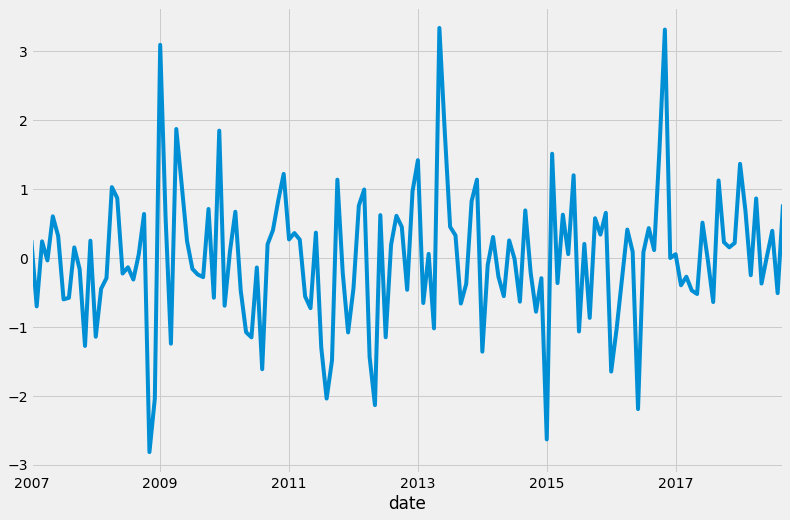

In [44]:
y_train.plot(figsize=(12, 8), legend=False)

<AxesSubplot:xlabel='date'>

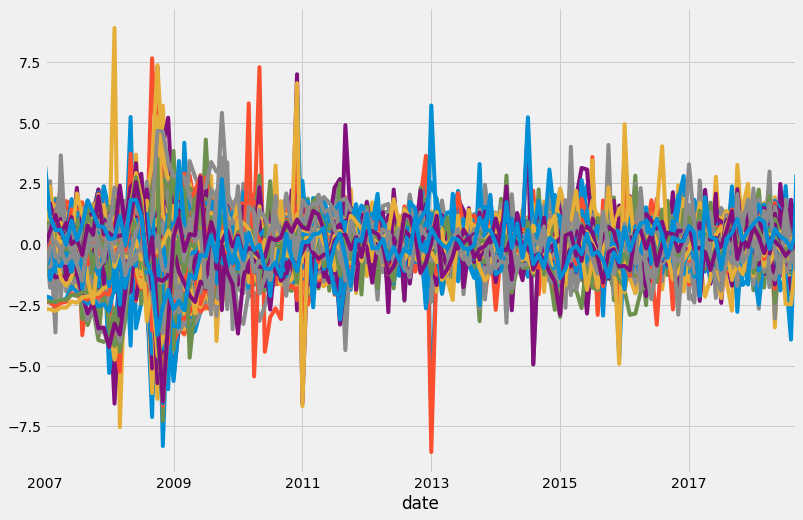

In [45]:
X_train.plot(figsize=(12, 8), legend=False)

In [46]:
# df.plot(subplots=True,
#         layout=(8, 3),
#         figsize=(22,22),
#         fontsize=10, 
#         linewidth=2,
#         sharex=False,
#         title='Visualization of the original Time Series')

### Time series cross-validation: TS split vs Block TS split

In [47]:
tscv = TimeSeriesSplit(n_splits=n_splits)

for i, (train_index, test_index) in enumerate(tscv.split(X)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58]
  Test:  index=[ 59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117]
Fold 1:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117]
  Test:  index=[118 119 120 121 122 1

In [48]:
block_tscv = BlockingTimeSeriesSplit(n_splits=n_splits)

for i, (train_index, test_index) in enumerate(block_tscv.split(X)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
  Test:  index=[44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]
Fold 1:
  Train: index=[ 88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131]
  Test:  index=[132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175]


In [49]:
def tscv_opt(X, y, model_wrapper):

    # define time series split
    time_split = TimeSeriesSplit(n_splits=n_splits)

    # choose search type
    if model_wrapper.search_type == 'random':
        model_search = RandomizedSearchCV(estimator=model_wrapper.ModelClass,
                                        param_distributions=model_wrapper.param_grid,
                                        n_iter=n_iter,
                                        cv=time_split,
                                        verbose=verbose,
                                        n_jobs=n_jobs,
                                        scoring=scoring,
                                        random_state=seed)
    elif model_wrapper.search_type == 'grid':
        model_search = GridSearchCV(estimator=model_wrapper.ModelClass,
                                    param_grid=model_wrapper.param_grid,
                                    cv=time_split,
                                    verbose=verbose,
                                    n_jobs=n_jobs,
                                    scoring=scoring)
    else:
        raise Exception('search type method not registered')

    # find best model
    model_fit = model_search.fit(X, y)

    return model_fit

### Lasso

In [50]:
# instantiate model wrapper
model_wrapper = LassoWrapper()
model_fit = tscv_opt(X=X_train_val, y=y_train_val, model_wrapper=model_wrapper)

# fit best model
lasso_best_fit = model_fit.best_estimator_.fit(X_train_val, y_train_val)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


Text(0, 0.5, 'Features')

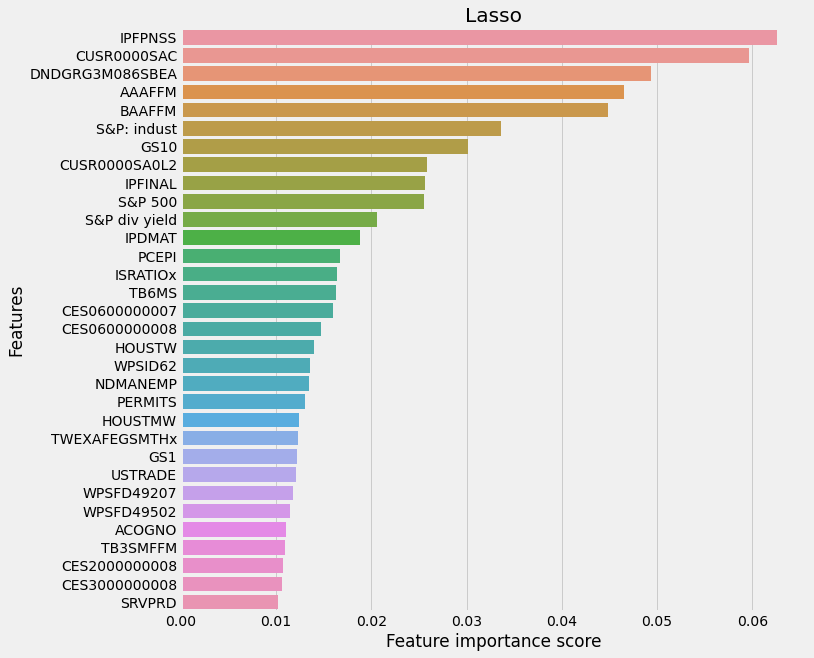

In [63]:
feature_scores = pd.Series(np.abs(lasso_best_fit.coef_) / np.sum(np.abs(lasso_best_fit.coef_)), index=X_train.columns).sort_values(ascending=False)

subset_feature_scores = feature_scores[feature_scores > 0.01]

f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x=subset_feature_scores, y=subset_feature_scores.index)
ax.set_title("Lasso")
ax.set_yticklabels(subset_feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")

In [19]:
# lasso_explainer = shap.Explainer(lasso_best_fit.predict, X_train)
# lasso_shap_values = lasso_explainer(X_train)

# shap.plots.beeswarm(lasso_shap_values, max_display=20, order=lasso_shap_values.abs.max(0))

### Random Forest

In [15]:
# instantiate model wrapper
model_wrapper = RandomForestWrapper()
model_fit = tscv_opt(X=X_train_val, y=y_train_val, model_wrapper=model_wrapper)

# fit best model
best_model_fit = model_fit.best_estimator_.fit(X_train_val, y_train_val)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


Text(0, 0.5, 'Features')

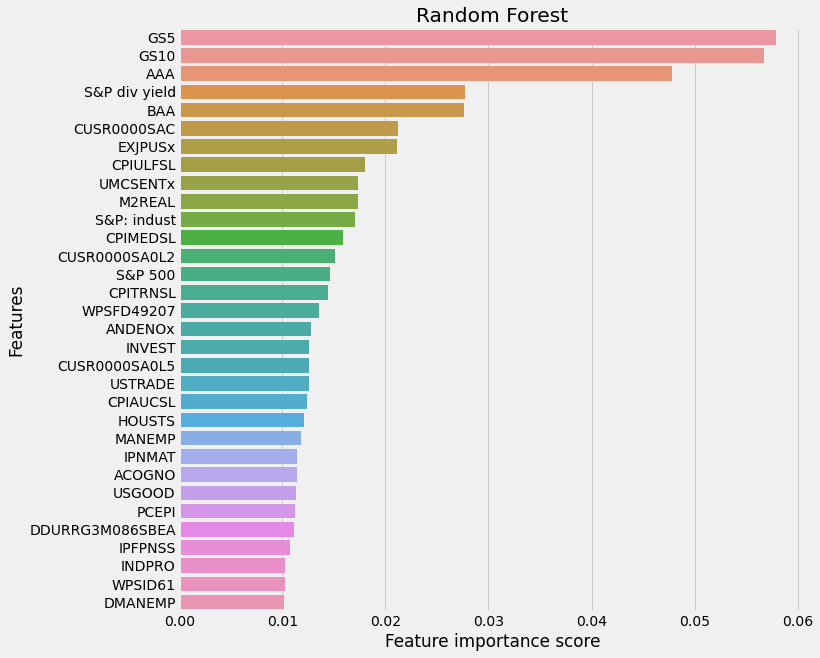

In [20]:
feature_scores = pd.Series(model_fit.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores = feature_scores / np.sum(feature_scores)

subset_feature_scores = feature_scores[feature_scores > 0.01]

f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x=subset_feature_scores, y=subset_feature_scores.index)
ax.set_title("Random Forest")
ax.set_yticklabels(subset_feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")

In [18]:
# explainer = shap.KernelExplainer(best_model_fit.predict, X_train)
# shap_values = explainer.shap_values(X_test)

# shap.plots.beeswarm(lasso_shap_values, max_display=20)